In [1]:
from matplotlib import pyplot as plt
import numpy as np
import collections

import torch
import datetime
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

In [2]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
data_path = '../data-unversioned/p1ch6/'
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))
cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
          for img, label in cifar10
          if label in [0, 2]]
cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [0, 2]]

first_model = nn.Sequential(
                nn.Linear(3072, 512),
                nn.Tanh(),
                nn.Linear(512, 2),
                nn.LogSoftmax(dim=1))
numel_list = [p.numel() for p in first_model.parameters()]
sum(numel_list), numel_list
conv = nn.Conv2d(3, 16, kernel_size=3) # <1>
conv
img, _ = cifar2[0]
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

Files already downloaded and verified
Files already downloaded and verified


[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

In [3]:
# Use Kernel-Size 3:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out
model = Net()
model(img.unsqueeze(0))
torch.save(model.state_dict(), data_path + 'birds_vs_airplanes.pt')
loaded_model = Net()  # <1>
loaded_model.load_state_dict(torch.load(data_path
                                        + 'birds_vs_airplanes.pt'))
device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))
print(f"Training on device {device}.")

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader,val_loader):

    loss_train_3 = np.zeros(n_epochs)
    loss_val_3 = np.zeros(n_epochs)

    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)  # <1>
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()

        loss_train_3[epoch-1] = loss_train/len(train_loader)

        loss_val = 0.0
        for imgs, labels in val_loader:
            imgs = imgs.to(device=device)  # <1>
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            #optimizer.zero_grad()
            #loss.backward()
            #optimizer.step()

            loss_val += loss.item()

        loss_val_3[epoch-1] = loss_val/len(val_loader)
        

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))
            print('{} Epoch {}, Validation loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_val / len(val_loader)))
            
    return loss_train_3, loss_val_3
            
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)

model = Net().to(device=device)  # <1>
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

loss_train_3,loss_val_3 = training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
    val_loader = val_loader
)
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)
all_acc_dict = collections.OrderedDict()

def validate(model, train_loader, val_loader):
    accdict = {}
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1) # <1>
                total += labels.shape[0]
                correct += int((predicted == labels).sum())

        print("Accuracy {}: {:.2f}".format(name , correct / total))
        accdict[name] = correct / total
    return accdict

all_acc_dict["baseline"] = validate(model, train_loader, val_loader)
sum(p.numel() for p in model.parameters())

Training on device cpu.
2023-06-05 17:36:20.267379 Epoch 1, Training loss 0.5760441373108299
2023-06-05 17:36:20.267507 Epoch 1, Validation loss 0.48801908548921347
2023-06-05 17:36:34.614801 Epoch 10, Training loss 0.3255056544284152
2023-06-05 17:36:34.614947 Epoch 10, Validation loss 0.32819165708497167
2023-06-05 17:36:49.225630 Epoch 20, Training loss 0.29095528716114677
2023-06-05 17:36:49.225737 Epoch 20, Validation loss 0.3073099898174405
2023-06-05 17:37:03.897016 Epoch 30, Training loss 0.2654876889316899
2023-06-05 17:37:03.897146 Epoch 30, Validation loss 0.2961933743208647
2023-06-05 17:37:18.082240 Epoch 40, Training loss 0.243670300028886
2023-06-05 17:37:18.082408 Epoch 40, Validation loss 0.28985905926674604
2023-06-05 17:37:32.315930 Epoch 50, Training loss 0.22543756905824516
2023-06-05 17:37:32.316055 Epoch 50, Validation loss 0.28763002529740334
2023-06-05 17:37:46.967658 Epoch 60, Training loss 0.20964666977999316
2023-06-05 17:37:46.967774 Epoch 60, Validation lo

18090

In [4]:
# Use Kernel-Size 5:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=5, padding=2)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out
    

model = Net()
model(img.unsqueeze(0))

torch.save(model.state_dict(), data_path + 'birds_vs_airplanes.pt')

loaded_model = Net()  # <1>
loaded_model.load_state_dict(torch.load(data_path
                                        + 'birds_vs_airplanes.pt'))


device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))
print(f"Training on device {device}.")

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader,val_loader):
    loss_train_5 = np.zeros(n_epochs)
    loss_val_5 = np.zeros(n_epochs)

    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)  # <1>
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()

        loss_train_5[epoch-1] = loss_train/len(train_loader)

        loss_val = 0.0
        for imgs, labels in val_loader:
            imgs = imgs.to(device=device)  # <1>
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            #optimizer.zero_grad()
            #loss.backward()
            #optimizer.step()

            loss_val += loss.item()

        loss_val_5[epoch-1] = loss_val/len(val_loader)
        

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))
            print('{} Epoch {}, Validation loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_val / len(val_loader)))
    return loss_train_5, loss_val_5


train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)

model = Net().to(device=device)  # <1>
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

loss_train_5,loss_val_5 = training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
    val_loader = val_loader
)


all_acc_dict = collections.OrderedDict()

def validate(model, train_loader, val_loader):
    accdict = {}
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1) # <1>
                total += labels.shape[0]
                correct += int((predicted == labels).sum())

        print("Accuracy {}: {:.2f}".format(name , correct / total))
        accdict[name] = correct / total
    return accdict

all_acc_dict["baseline"] = validate(model, train_loader, val_loader)

sum(p.numel() for p in model.parameters())

Training on device cpu.
2023-06-05 17:38:46.583486 Epoch 1, Training loss 0.5420166571049174
2023-06-05 17:38:46.583611 Epoch 1, Validation loss 0.4777344837784767
2023-06-05 17:39:07.446264 Epoch 10, Training loss 0.3221918683333002
2023-06-05 17:39:07.446431 Epoch 10, Validation loss 0.3342174063436687
2023-06-05 17:39:29.340888 Epoch 20, Training loss 0.28330858070759257
2023-06-05 17:39:29.341051 Epoch 20, Validation loss 0.31198497116565704
2023-06-05 17:39:51.447349 Epoch 30, Training loss 0.2527227841175286
2023-06-05 17:39:51.447477 Epoch 30, Validation loss 0.3076569391414523
2023-06-05 17:40:13.675610 Epoch 40, Training loss 0.22670148787604774
2023-06-05 17:40:13.675736 Epoch 40, Validation loss 0.3210869347676635
2023-06-05 17:40:36.120392 Epoch 50, Training loss 0.20346238938676323
2023-06-05 17:40:36.120560 Epoch 50, Validation loss 0.33155378699302673
2023-06-05 17:40:58.101327 Epoch 60, Training loss 0.18133456430807235
2023-06-05 17:40:58.101437 Epoch 60, Validation lo

20906

<function matplotlib.pyplot.show(close=None, block=None)>

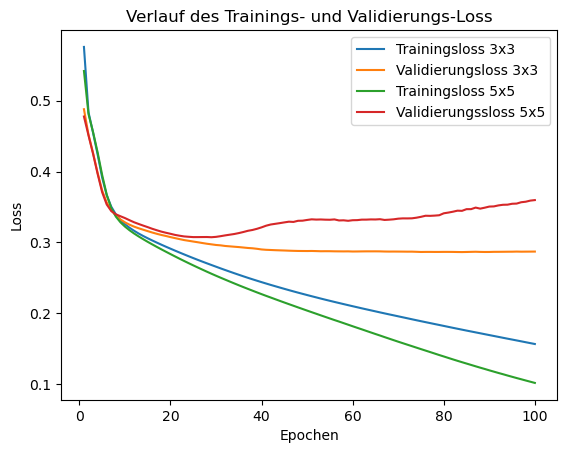

In [5]:
epochs = np.arange(1, 101, 1)

plt.plot(epochs, loss_train_3, label = 'Trainingsloss 3x3')
plt.plot(epochs, loss_val_3, label = 'Validierungsloss 3x3')
plt.plot(epochs, loss_train_5, label = 'Trainingsloss 5x5')
plt.plot(epochs, loss_val_5, label = 'Validierungssloss 5x5')
plt.xlabel("Epochen")
plt.ylabel("Loss")
plt.legend()
plt.title("Verlauf des Trainings- und Validierungs-Loss")
plt.show

Wie verändert sich die Anzahl der freien Parameter im Modell?
    Man kann erkennen, dass sich die freien Parameter im Modell erhöhen. In diesem Fall von 18090 auf 20906.

Verbessert oder verschlechtert sich Overfitting?
    Das Overfitting verschlechtert sich bei der Erhöhung der Kernelsize. Dies begründet sich in der gesetigerten Komplexität des Netzes.

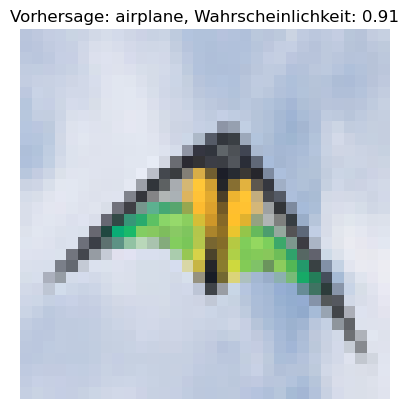

In [23]:
# Suchen eines Bildes, weder Vogel noch Flugzeug, das aber mit 95% einer Gruppe zugeordnet wird:

# Versuch 1: 

import numpy as np
from PIL import Image
import torch

image = Image.open('Lenkdrache.png')

resized_image = image.resize((32, 32))

image_resized = np.delete(resized_image, -1, axis=2)

tensor = torch.from_numpy(image_resized)

tensor = tensor.permute(2, 0, 1).float()

output = model(tensor)
output = F.softmax(output,dim=1)
confi, predicted = torch.max(output, dim=1) 

label_dragon = class_names[predicted.item()]
confi_dragon = confi.item()


plt.imshow(image_resized)
plt.title(f"Vorhersage: {label_dragon}, Wahrscheinlichkeit: {confi_dragon:.2f}")
plt.axis('off')
plt.show()

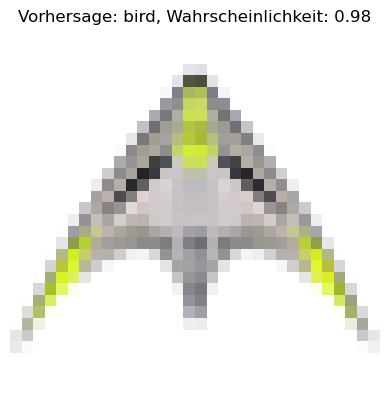

In [27]:
# Versuch 1: 

import numpy as np
from PIL import Image
import torch

image = Image.open('Lenkdrache2.jpg')

resized_image = image.resize((32, 32))

image_resized = np.array(resized_image)

tensor = torch.from_numpy(image_resized)

tensor = new_tensor = tensor.permute(2, 0, 1).float()

output = model(tensor)
output = F.softmax(output,dim=1)
confi, predicted = torch.max(output, dim=1) 

label_dragon = class_names[predicted.item()]
confi_dragon = confi.item()


plt.imshow(image_resized)
plt.title(f"Vorhersage: {label_dragon}, Wahrscheinlichkeit: {confi_dragon:.2f}")
plt.axis('off')
plt.show()